# Part 1 - Exploratory Data Analysis & Preprocessing
In my last yeay's [eargasm music project](https://github.com/adamsiemaszkiewicz/eargasm-music), I classified my music library using pre-developed audio features extracted using Spotify API. This project is an attempt to test new ways of classifying sounds based on their raw sound representation and, later on, try to ensamble various different methods for a better performing classifier.

This notebook will import the dataset, explore and visualize the data and preprocess the audio files for later usage.

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/sound_classifier': File exists
/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries
- `numpy` - linear algebra
- `pandas` -  data manipulation & analysis
- `os` - operating system interfaces
- `tqdm` - progress bars
- `matplotlib` - visualization plotting
- `librosa` - audio & music processing
- `IPython.display` - audio previews

In [3]:
import numpy as np
import pandas as pd
import os
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import librosa
import IPython.display as display

# Dataset
For this task I'm going to use Karol Piczak's [ESC-50: Dataset for Environmental Sound Classification](https://github.com/karolpiczak/ESC-50). The ESC-50 dataset is a labeled collection of 2000 environmental audio recordings and consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories: 
- Animals	
- Natural soundscapes & water sounds	
- Human, non-speech sounds	
- Interior/domestic sounds	
- Exterior/urban noises

## Clone repository
The dataset is available through various sources. I'll use Karol's repository to access it.

In [4]:
if not os.path.isdir('./ESC-50/'):
  !git clone https://github.com/karolpiczak/ESC-50.git

## Set paths

In [5]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

# path to folder containing audio files
AUDIO_PATH = './ESC-50/audio/'

### Preview dataset
Import CSV file containing meta information about the files in the dataset into a dataframe.

In [6]:
df = pd.read_csv(META_CSV)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


For the purposes of our task we'll only need the columns containing:
- filename for easy access,
- fold number for cross-validation
- target & category for labels

# Exploratory Data Analysis
Let's explore the data we're working with.

## Categories
Our dataset consists of 50 different categories of sounds, each with 40 samples.

In [7]:
categories = df.groupby('category').size()
print(f'Number of categories: {categories.shape[0]}')

Number of categories: 50


In [8]:
categories

category
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog                 40
door_wood_creaks    40
door_wood_knock     40
drinking_sipping    40
engine              40
fireworks           40
footsteps           40
frog                40
glass_breaking      40
hand_saw            40
helicopter          40
hen                 40
insects             40
keyboard_typing     40
laughing            40
mouse_click         40
pig                 40
pouring_water       40
rain                40
rooster             40
sea_waves           40
sheep               40
siren               40
sneezing            40
snoring             40
th

## Sample file
Let's explore a sample audio file for its features.

### Basic info
Let's see the technicals of a sample audio file such as its:
- category name
- sample rate (the number of 'samples' taken per second measured in Hertz)
- clip length (in seconds)
- audio signal (array of amplitudes for each sample)

In [9]:
# generate random integer
random_int = np.random.randint(0, high=df.shape[0])
# select a random row
row = df.iloc[random_int]
# generate a filepath
filepath = AUDIO_PATH+row['filename']

# open the audio file and extract 
clip, sample_rate = librosa.load(
    filepath,
    sr=None # use the native sample rate
    )

# extract cateory name
category = row['category']
# calculate clip length
clip_length = (len(clip)/sample_rate)

print(f'''
Category:      {category}
Sample rate:   {sample_rate}Hz
Clip length:   {clip_length:3.2f} seconds
Audio signal:  {clip}
''')


Category:      sneezing
Sample rate:   44100Hz
Clip length:   5.00 seconds
Audio signal:  [3.0517578e-05 3.0517578e-05 3.0517578e-05 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]



### Audio preview
Listen to the sample audio file.

In [10]:
def listen_example(filepath):
  '''
  Takes the filepath to the audio file and outputs a preview audio player..

  Parameters:
  filepath (str): A path to the audio file

  Returns:
  audio player (IPython.lib.display.Audio)
  '''
  return display.Audio(filepath)

In [11]:
listen_example(filepath)

### Signal & spectogram
The audio file can be visually represented using different methods such as:
1. Audio signal which shows the changes in air pressure (volume) of each audio sample
2. Spectogram, which shows the spectrum of frequencies of a signal throughout time using [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FTT).

One one hand, the audio signal representation gives us only the information about the loudness of the track, which is not too informative. 

On the other hand, spectogram is way more information-dense. Apart from showing the change of sound frequencies in time, it also highlights their loudness in dB with colour.

For the purpose of our task, obviously, we're interested in the one which is more informative - spectogram :)

In [12]:
def plot_signal_and_spectogram(clip, sample_rate):
  '''
  Takes the audio clip and plots its audio signal and spectogram

  Parameters:
  clip (ndarray): An audio clip represented as an array
  sample_rate (int): A sample rate of the clip

  Returns:
  Subplot containing audio signal and spectogram plots.
  '''

  # set up the subplots
  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  # adjust height & width of the padding between subplots
  fig.subplots_adjust(hspace = .1, wspace=.2)
  # ravel axes to a flattened array 
  axs = axs.ravel()

  # plot audio signal
  x = range(len(clip))
  y = clip
  axs[0].plot(x, y)

  # annotate and set axes limits
  axs[0].set_title('Audio signal')
  axs[0].set_xlabel('Sample number')
  axs[0].set_ylabel('Volume amplitude')
  axs[0].set_ylim(-1, 1) # signal varies between -1 & 1
  axs[0].set_xlim(0, len(clip))

  # plot spectogram
  axs[1].specgram(
      clip,             # audio clip array
      Fs=sample_rate,   # sampling rate
      mode='psd',       # type of spectrum (default: psd)
      scale='dB'        # scaling of values in the spec
      )

  # annotate spectogram
  axs[1].set_title('Spectogram')
  axs[1].set_xlabel('Time (seconds)')
  axs[1].set_ylabel('Frequency (Hz)')

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


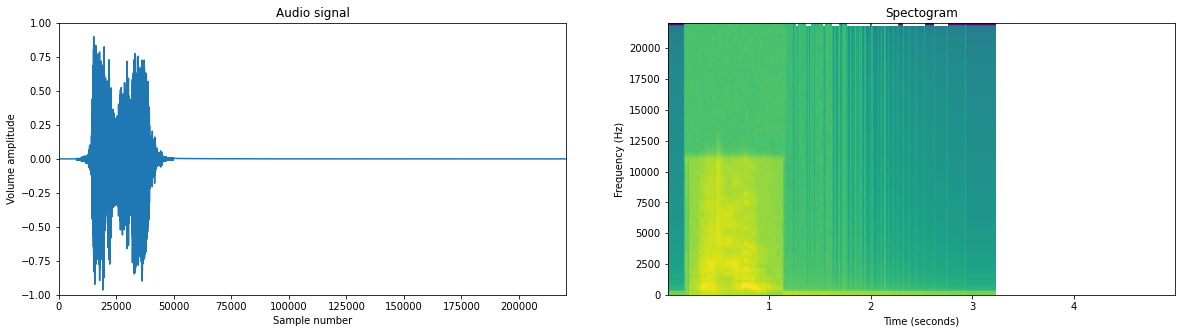

In [13]:
plot_signal_and_spectogram(clip, sample_rate)

In [23]:
n_fft = 1024
hop_length = 256
n_mels = 40
fmin = 20
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, sr=sample_rate, power=1.0, fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

# Preprocessing
Let's save the spectogram representation of our audio files as image files.

In [14]:
def save_spectogram(filename, input_dir, output_dir):
  '''
  Takes the audio clip filename and converts it into spectogram image.

  Parameters:
  filename (str): name of the file
  input_dir (str): input path
  output_dir (str): output path
  '''
  
  # generate the filepath
  audio = input_dir+filename
  image = output_dir+filename.split('.')[0]+'.png'
  
  # check if the file already exists
  if not os.path.exists(output_dir):
    
    # open audio file
    clip, sample_rate = librosa.load(
        audio,
        sr=None
        )
    
    # plot the spectogram
    plt.specgram(
          clip,
          Fs=sample_rate,
          mode='psd',
          scale='dB'
          )
    
    # switch off the axis
    plt.axis('off')
    
    # save the spectogram without bounding box
    plt.savefig(
          image,
          bbox_inches='tight',
          pad_inches=0
          )

In [15]:
# path to folder containing audio files
SPECTOGRAM_PATH = './spectograms/'

# save a spectogram representation for each audio file
for filename in tq.tqdm(df['filename']):
  save_spectogram(filename, AUDIO_PATH, SPECTOGRAM_PATH)

Now we're ready to build a sound classifier based on the spectogram images.

References:
- [Getting to Know the Mel Spectogram](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0)